In [1]:
# Import everything, load data, configured training params
from CleanDriver_v2 import Driver
from pfc import *
import numpy as np
from numpy import ma
import math
import time
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn-paper')
%matplotlib inline

agg = np.load('loaded_data0.npy')
output_num = len(agg) + 1  # target "neuron"
num_neurons = 1300

# rearrange the targets to make iterating easier
agg = [[ agg[i][j] for i in range(len(agg)) ] for j in range(72) ]

""" Normalize a run between min and max"""
def normalize(run, min_, max_):
    """
    Args:
        run : array_like - the set of data we want to normalize
        min_ : float - the minimum value our result should take
        max_ : float - the maximum value our result should take
        
    Returns:
        array_like - normalized run
    """
    return min_ + ((run - np.min(run)) * (max_ - min_)) / (np.max(run) - np.min(run))

""" Inverse of tanh(x) function"""
def inv_tanh(x):
    return 0.5 * np.log((1 + x) / (1 - x))

""" Inverse of 1/(1+e^(-x)) function"""
def inv_sig(x):
    return np.log(x / (1 - x))

""" 1/(1+e^(-x)) function"""
def sig(x):
    return 1 / (1 + np.exp(-x))

# normalize run so that we can pass it through the inverse sigmoidal function
# which is undefined outself of (0, 1)
agg = np.array([normalize(agg[i], 0.1, 0.9) for i in range(len(agg))])
transformed = np.array([ inv_sig(agg[i]) for i in range(len(agg)) ])

""" Not to be confused with sig(x) = 1/(1+e^(-x)), the sigmoid function is how
    we ask the network to report behavioral response variable"""
def sigmoid(x):
    return x / math.sqrt(100 + x * x)

# various behavioral response types
poss_maps = {
    'baseline': np.zeros(len(agg[0][0])),
    'pos'     : [sigmoid(i) for i in range(len(agg[0][0]))],
    'neg'     : [-1 * sigmoid(i) for i in range(len(agg[0][0]))],
    'r_pos'   : [1 - sigmoid(i) for i in range(100)],
    'r_neg'   : [-1 * (1 - sigmoid(i)) for i in range(100)],
    'base'    : np.zeros(100)
}

#  Configure training vectors; a vector takes the form:
#  [ color_coherence, motion_coherence, color_context, motion_context, return_cue ].
#  In the color context, color_context=1 & motion_context=0. In the motion context
#  color_context=0 & motion_context=1. No sensory evidence should be present when the
#  return cue is on.
cv   = [-0.5, -0.17, -0.05, 0.05, 0.17, 0.5] # color values
ret = [0, 0, 0, 0, 1] # return cue
vecs = []  # context / coherence vecs

for i in range(2):
    for j in range(len(cv)):
        for k in range(len(cv)):
            if i == 0: vecs.append((np.array([ cv[j], cv[k], 1, 0, 0 ]), True if cv[j] > 0 else False, 6*j + k))
            else: vecs.append((np.array([ cv[j], cv[k], 0, 1, 0 ]), True if cv[k] > 0 else False, 36+6*j+k))

appendpos = np.append(poss_maps['pos'], poss_maps['r_pos'])
appendneg = np.append(poss_maps['neg'], poss_maps['r_neg'])

In [2]:
# Set parameters for driver and initialize
chaotic_constant = 1.4; input_num = 5; gg_sparseness = 0.9; 
alpha = 1.0; dt = 0.1; p = 0.1; sigma = 0.0; epochs = 6;
driv = Driver(num_neurons, p, chaotic_constant, input_num, output_num, 
              gg_sparseness, alpha, dt, sigma, sig, target_in_network=True)

Initializing Driver...
 > > > > > Initializing network...
 > > > > > Network initialized.
Driver initialized.


In [3]:
# Train the network
base = np.zeros(80) # wait 200 ms
basenet = [ base for i in range(output_num) ]
def train(batch, vec):
    print '.', # progress
    gain = [ np.linspace(0, batch[p][0], 20) for p in range(output_num) ]
    driv.train(gain, vec) # smooth gain
    driv.train(batch, vec) # correspondence between data and context    
    decline = [ np.linspace(batch[p][-1], 0, 20) for p in range(output_num) ]
    driv.train(decline, ret) # smooth decline   
    driv.train(basenet, ret) # let network settle

start = time.time()
for epoch in range(epochs):
    print('')
    if epoch == int(round(float(epochs) / 4)):
        end = time.time()
        print('')
        print("[ 25%] training complete.", end - start, "seconds ellapsed.")
    if epoch == int(round(float(epochs) / 2)):
        end = time.time()
        print('')
        print("[ 50%] training complete.", end - start, "seconds ellapsed.")
    if epoch == int(round(3 * (float(epochs) / 4))):
        end = time.time()
        print('')
        print("[ 75%] training complete.", end - start, "seconds ellapsed.")
    np.random.shuffle(vecs)
    for i in range(len(vecs)):
        if i == len(vecs) / 2: 
            print('')
            print("Processed 50% of contexts")
        targ = list(transformed[vecs[i][2]])
        if vecs[i][1]: targ.append(appendpos)
        else: targ.append(appendneg)
        train(targ, vecs[i][0])

end = time.time()
print('')
print("[100%] training complete.", end - start, "seconds ellapsed.")


. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Processed 50% of contexts
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Processed 50% of contexts
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 

('[ 25%] training complete.', 713.350508928299, 'seconds ellapsed.')
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Processed 50% of contexts
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 

('[ 50%] training complete.', 1067.7011699676514, 'seconds ellapsed.')
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Processed 50% of contexts
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Processed 50% of contexts
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 

In [4]:
ICs = []  # inital conditions
res = [ [ [] for i in range(72) ] for t in range(4) ]  # results of tests
N = 5
for q, noise in enumerate([0.0, 0.1, 0.25, 0.5]):  # different noise values
    print('Testing new context')
    for t in range(len(vecs)):  # iterate over all contexts
        print '.',
        for iter_ in range(N):  # N trials per context
            ICs.append((driv.network.membrane_potential, vecs[t][0]))
            test = list(agg[t])
            if vecs[t][1]: test.append(appendpos)
            else: test.append(appendneg)

            gain = [ np.linspace(0, test[p][0], 20) for p in range(len(test)) ]
            phase_1 = driv.test(gain, vecs[t][0])
            ICs.append((driv.network.membrane_potential, vecs[t][0]))

            phase_2 = driv.test(test, vecs[t][0], twn=True, scale=noise)
            ICs.append((driv.network.membrane_potential, vecs[t][0]))

            drop = [ np.linspace(0, test[t][-1], 20) for p in range(len(test)) ]
            drop.append(test[-1][0:20])
            phase_3 = driv.test(drop, ret)
            ICs.append((driv.network.membrane_potential, vecs[t][0]))

            phase_4 = driv.test(basenet, ret)
            ICs.append((driv.network.membrane_potential, vecs[t][0]))
            if res[q][t] == []:
                res[q][t] = np.concatenate((phase_1, phase_2, phase_3, phase_4), axis=1)
            else:
                res[q][t] = res[q][t] + np.concatenate((phase_1, phase_2, phase_3, phase_4), axis=1)
        res[q][t] /= N

Testing new context
.

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:28: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . Testing new context
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . Testing new context
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . Testing new context
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


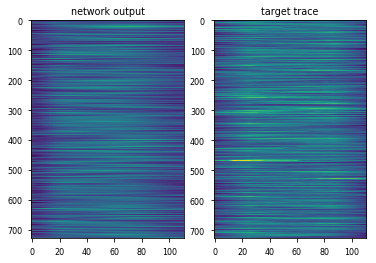

In [5]:
# see some results
plt.figure()
plt.subplot(121)
plt.imshow(np.array(res[0])[0][:,20:131], aspect='auto')
plt.title("network output")
plt.subplot(122)
plt.title("target trace")
plt.imshow(agg[0], aspect='auto')

Text(0.5,1,u'example behavioral response')

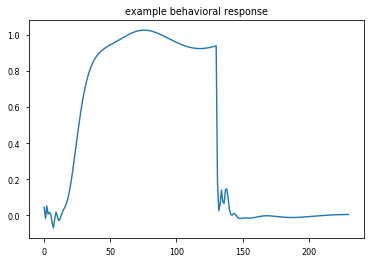

In [6]:
plt.figure()
plt.plot(res[0][0][-1])
plt.title("example behavioral response")

In [8]:
# Other experiment: get percent correct/incorrect guesses by the network
res_counts = [ [ [ [] for i in range(72) ] for k in range(2) ] for q in range(7) ]
counts = [ [ np.zeros(72) for k in range(2) ] for q in range(7) ]
n_pres_dur = 111; HIT = 0; MISS = 1;

for q, noise in enumerate([0.0, 0.1, 0.25, 0.5, 0.75, 1, 1.5]):
    print()
    print('noise at', noise)
    for t in range(len(vecs)):
        print '.',
        for z in range(5):
            test = list(agg[t])
            if vecs[t][1]: test.append(appendpos)
            else: test.append(appendneg)

            gain = [ np.linspace(0, test[p][0], 20) for p in range(len(test)) ]
            a1 = driv.test(gain, vecs[t][0])
            ICs.append((driv.network.membrane_potential, vecs[t][0]))

            a2 = driv.test(test, vecs[t][0], twn=True, scale=noise)
            ICs.append((driv.network.membrane_potential, vecs[t][0]))

            drop = [ np.linspace(0, test[t][-1], 20) for p in range(len(test)) ]
            drop.append(test[-1][0:20])
            a3 = driv.test(drop, ret)
            ICs.append((driv.network.membrane_potential, vecs[t][0]))

            a4 = driv.test(basenet, ret)
            ICs.append((driv.network.membrane_potential, vecs[t][0]))
            
            response = np.concatenate((a1, a2, a3, a4), axis=1)
            mag = np.array(response[-1][20:20+n_pres_dur])
            check = (mag < 0).sum() # check how many time bins are negatvie
            if check >= n_pres_dur/2: # more neg bins, neg response
                # if it should have been positive
                if vecs[t][1]: # MISS
                    if res_counts[q][MISS][t] == []: res_counts[q][MISS][t] = response
                    else: res_counts[q][MISS][t] = res_counts[q][MISS][t] + response
                    counts[q][MISS][t] += 1
                else: # HIT
                    if res_counts[q][HIT][t] == []: res_counts[q][HIT][t] = response
                    else: res_counts[q][HIT][t] = res_counts[q][HIT][t] + response
                    counts[q][HIT][t] += 1
            else: # more pos bins
                # if it should have been positive
                if vecs[t][1]: # HIT
                    if res_counts[q][HIT][t] == []: res_counts[q][HIT][t] = response
                    else: res_counts[q][HIT][t] = res_counts[q][HIT][t] + response
                    counts[q][HIT][t] += 1
                else: # MISS
                    if res_counts[q][MISS][t] == []: res_counts[q][MISS][t] = response
                    else: res_counts[q][MISS][t] = res_counts[q][MISS][t] + response
                    counts[q][MISS][t] += 1
    if not counts[q][HIT][t] == 0:
        res_counts[q][HIT][t] /= counts[q][HIT][t]
    if not counts[q][MISS][t] == 0:
        res_counts[q][MISS][t] /= counts[q][MISS][t]

()
('noise at', 0.0)
.

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:47: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


 . . . .

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:41: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . ()
('noise at', 0.1)
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . ()
('noise at', 0.25)
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . ()
('noise at', 0.5)
. . . . . . . . . . . . . . . . . . . .

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:51: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:37: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


 ()
('noise at', 0.75)
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . ()
('noise at', 1)
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . ()
('noise at', 1.5)
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
